# Hand-written digit generation using DCGAN (Deep Convolutional GAN)

In [1]:
import torch
from torch import nn
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

<h3>Set device</h3>

In [2]:
device = 'cuda'

<h3>Generator</h3>

In [3]:
class Generator(nn.Module):
    
    """
    Generator of the DCGAN.
    
    Parameters
    ----------
    noise_channel: int
        number of channels in the random noise vector.
    hidden_channels: tuple
        tuple of numbers of channels in the hidden layers.
    image_channel: int
        number of channels in the image generated.
    kernel_sizes: tuple
        tuple of kernel sizes.
    strides: tuple
        tuple of kernel strides.
    """
    
    def __init__(self, noise_channel, hidden_channels, image_channel, kernel_sizes, strides):
        
        super(Generator, self).__init__()
        
        self.noise_channel = noise_channel
        self.hidden_channels = hidden_channels
        self.image_channel = image_channel
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        
        layers_list = []
        
        curr_input_channel = noise_channel
        
        for hidden_channel, kernel_size, stride in zip(hidden_channels,kernel_sizes, strides):
            layer = nn.Sequential(nn.ConvTranspose2d(curr_input_channel, hidden_channel, kernel_size, stride),
                                  nn.BatchNorm2d(hidden_channel),
                                  nn.ReLU())
            layers_list.append(layer)
            curr_input_channel = hidden_channel
        
        layer = nn.Sequential(nn.ConvTranspose2d(hidden_channel, image_channel, kernel_sizes[-1], strides[-1]))
        layers_list.append(layer)
        
        self.generator = nn.Sequential(*layers_list)
        
    
    def forward(self, noise_vectors):
        
        """
        Perform the forward pass.

        Parameters
        ----------
        noise_vectors: Tensor
            batch of random noise vectors.

        Returns
        -------
        images: Tensor
            images generated from the noise vectors.
        """
        
        # reshape noise vectors to the shape - batch x channels x height x width
        noise_vectors_unsqueezed = noise_vectors.view(len(noise_vectors),self.noise_channel, 1, 1)
        images = self.generator(noise_vectors_unsqueezed)
        return images

<h3>Discriminator</h3>

In [4]:
class Discriminator(nn.Module):
    
    """
    Discriminator of the DCGAN.
    
    Parameters
    ----------
    hidden_channels: tuple
        tuple of numbers of channels in the hidden layers.
    image_channel: int
        number of channels in the image generated.
    kernel_sizes: tuple
        tuple of kernel sizes.
    strides: tuple
        tuple of kernel strides.
    """
    
    def __init__(self, image_channel, hidden_channels, kernel_sizes, strides):
        super(Discriminator, self).__init__()
        
        self.image_channel = image_channel
        self.hidden_channels = hidden_channels
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        
        layers_list = []
        curr_input_channel = image_channel
        
        for hidden_channel, kernel_size, stride in zip(hidden_channels, kernel_sizes, strides):
            layer = nn.Sequential(nn.Conv2d(curr_input_channel, hidden_channel, kernel_size, stride),
                                  nn.BatchNorm2d(hidden_channel),
                                  nn.LeakyReLU(negative_slope = 0.2))
            layers_list.append(layer)
            curr_input_channel = hidden_channel
        
        layer = nn.Sequential(nn.Conv2d(hidden_channel, 1, kernel_sizes[-1], strides[-1]), nn.Sigmoid())
        layers_list.append(layer)
        
        self.discriminator = nn.Sequential(*layers_list)
    
    def forward(self, images):
        
        """
        Perform the forward pass.

        Parameters
        ----------
        images:
            batch of images.

        Returns
        -------
        predictions: Tensor
            binary predictions of the input images.
        """
        
        predictions = self.discriminator(images).squeeze()
        return predictions

<h3>function to compute generator's loss</h3>

In [5]:
def get_generator_loss(generator, discriminator, criterion, noise_vectors):
    
    """
    Compute the binary cross entropy loss of the generator.

    Parameters
    ----------
    generator: Generator
        generator object
    discriminator: Discriminator
        discriminator object
    criterion: BCELoss
        object to compute generator's loss
    noise_vectors: Tensor
        batch of random noise vectors

    Returns
    -------
    loss: Tensor
        generator's BCE loss.
    """
    
    fake_images = generator(noise_vectors)
    fake_pred = discriminator(fake_images)
    fake_target = torch.ones_like(fake_pred)
    loss = criterion(fake_pred, fake_target)
    
    return loss

<h3>function to compute discriminator's loss</h3>

In [6]:
def get_discriminator_loss(generator, discriminator, criterion, noise_vectors, real_images):
    
    """
    Compute the binary cross entropy loss of the generator.

    Parameters
    ----------
    generator: Generator
        generator object
    discriminator: Discriminator
        discriminator object
    criterion: BCELoss
        object to compute generator's loss
    noise_vectors: 
        batch of random noise vectors
    real_images: 
        batch of real images

    Returns
    -------
    loss: Tensor
        discriminator's BCE loss.
    """
    
    loss = 0
    
    fake_images = generator(noise_vectors)
    fake_pred = discriminator(fake_images)
    fake_target = torch.zeros_like(fake_pred)
    loss += criterion(fake_pred, fake_target)
    
    real_pred = discriminator(real_images)
    real_target = torch.ones_like(real_pred)
    loss += criterion(real_pred, real_target)
    
    return loss

<h3>function to initialize weights of generator and discriminator</h3>

In [7]:
def initialize_weights(module):
    
    """
    Initialize the weights of generator and discriminator.
    
    Parameters
    ----------
    module: nn.Module
        module whose weights are to be initialized.
        
    Returns
    -------
    None
    """
    
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(module.weight, 0.0, 0.02)
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.normal_(module.weight, 0.0, 0.02)
        nn.init.constant_(module.bias, 0.0)

<h3>function to show generated images</h3>

In [8]:
def show_images(images, image_size = (28,28)):
    
    """
    Show the grid of images.

    Parameters
    ----------
    images: Tensor
        batch of images to be displayed.
    image_size: tuple
        size of an image.

    Returns
    -------
    None
    """

    images = images.detach().cpu().view(-1, *image_size)
    image_grid = make_grid(images, nrow = 5).permute(1,2,0)
    plt.imshow(image_grid)
    plt.show()

<h3>set noise and image channels</h3>

In [9]:
noise_channel = 64

image_channel = 1

<h3>create generator</h3>

In [10]:
generator = Generator(noise_channel = noise_channel,
                      hidden_channels = (256, 128, 64),
                      image_channel = image_channel,
                      kernel_sizes = (3, 4, 3, 4),
                      strides = (2, 1, 2, 2)).to(device)

<h3>create discriminator</h3>

In [11]:
discriminator = Discriminator(image_channel = image_channel,
                              hidden_channels = (16, 32),
                              kernel_sizes = (4, 4, 4),
                              strides = (2, 2, 2)).to(device)

<h3>initialize weights of generator and discriminator</h3>

In [12]:
generator = generator.apply(initialize_weights)
discriminator = discriminator.apply(initialize_weights)

<h3>train GAN</h3>

In [13]:
num_epochs = 100 # number of epochs

batch_size = 128 # number of images in a batch

criterion = nn.BCELoss() # object to compute loss of generator and discriminator

learning_rate = 0.0002 # larning rate of the optimizers
betas = (0.5, 0.999)

generator_optim = torch.optim.Adam(generator.parameters(), lr = learning_rate, betas = betas) # generator's optimizer

discriminator_optim = torch.optim.Adam(discriminator.parameters(), lr = learning_rate, betas = betas) # discriminator's optimizer

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# MNIST data loader
data_loader = DataLoader(MNIST('.', download = True, transform = transform), 
                        batch_size = batch_size, shuffle = True)

for epoch in range(num_epochs):
    
    mean_generator_loss = 0
    mean_discriminator_loss = 0
    counter = 0
    
    for real_images, _ in tqdm(data_loader):
        
        curr_batch_size = real_images.shape[0] # number of real images in a batch
        real_images = real_images.to(device) # flatten images
        
        # train discriminator
        
        noise_vectors = torch.randn(curr_batch_size, noise_channel, device = device) # random noise vectors
        discriminator_optim.zero_grad() # set gradients of tensors to 0.
        discriminator_loss = get_discriminator_loss(generator, discriminator, criterion, noise_vectors, real_images)
        discriminator_loss.backward(retain_graph = True) # compute the gradients
        discriminator_optim.step() # optimize using gradients
        
        # train generator
        
        noise_vectors = torch.randn(curr_batch_size, noise_channel, device = device) # random noise vectors
        generator_optim.zero_grad() # set gradients of tensors to 0.
        generator_loss = get_generator_loss(generator, discriminator, criterion, noise_vectors)
        generator_loss.backward(retain_graph = True) # compute the gradients
        generator_optim.step() # optimize using gradients
        
        mean_generator_loss += generator_loss.item()
        mean_discriminator_loss += discriminator_loss.item()
        counter += 1
    
    mean_generator_loss /= counter
    mean_discriminator_loss /= counter
    
    # print current losses
    print(f"Epoch {epoch+1} : Generator's loss : {mean_generator_loss}, Discriminator's loss : {discriminator_loss}")


Epoch 1 : Generator's loss : 0.8704052848348232, Discriminator's loss : 0.645437479019165



Epoch 2 : Generator's loss : 2.1980996014975283, Discriminator's loss : 0.13240806758403778



Epoch 3 : Generator's loss : 3.4281898576821854, Discriminator's loss : 0.04695231467485428



Epoch 4 : Generator's loss : 1.7947481563414083, Discriminator's loss : 0.8190617561340332



Epoch 5 : Generator's loss : 1.33198315604155, Discriminator's loss : 0.7896736264228821



Epoch 6 : Generator's loss : 1.3739030258233613, Discriminator's loss : 0.8505553603172302



Epoch 7 : Generator's loss : 1.343877667557202, Discriminator's loss : 0.7339727282524109



Epoch 8 : Generator's loss : 1.3618170352124457, Discriminator's loss : 0.6791483759880066



Epoch 9 : Generator's loss : 1.3960901808891215, Discriminator's loss : 0.7561561465263367



Epoch 10 : Generator's loss : 1.4068509862621201, Discriminator's loss : 0.7949419021606445



Epoch 11 : Generator's loss : 1.4058353583187437, Discriminator's loss : 0.6801563501358032



Epoch 12 : Generator's loss : 1.4348891179190515, Discriminator's loss : 0.7796807885169983



Epoch 13 : Generator's loss : 1.4563804840736552, Discriminator's loss : 0.7330970764160156



Epoch 14 : Generator's loss : 1.460993215473476, Discriminator's loss : 0.78993159532547



Epoch 15 : Generator's loss : 1.460925409280415, Discriminator's loss : 0.6205475330352783



Epoch 16 : Generator's loss : 1.4295010611192505, Discriminator's loss : 0.6581945419311523



Epoch 17 : Generator's loss : 1.3806257215517161, Discriminator's loss : 0.6777597665786743



Epoch 18 : Generator's loss : 1.3232625251385703, Discriminator's loss : 0.7496770620346069



Epoch 19 : Generator's loss : 1.2807203951293726, Discriminator's loss : 0.9973503351211548



Epoch 20 : Generator's loss : 1.2797713003305993, Discriminator's loss : 0.9002661108970642



Epoch 21 : Generator's loss : 1.268075290773469, Discriminator's loss : 0.9004715085029602



Epoch 22 : Generator's loss : 1.2455165788435987, Discriminator's loss : 0.8151753544807434



Epoch 23 : Generator's loss : 1.2408622639901095, Discriminator's loss : 0.8598027229309082



Epoch 24 : Generator's loss : 1.222289130059895, Discriminator's loss : 0.9335999488830566



Epoch 25 : Generator's loss : 1.2082993574996492, Discriminator's loss : 0.8899791240692139



Epoch 26 : Generator's loss : 1.19850030223698, Discriminator's loss : 0.8998178243637085



Epoch 27 : Generator's loss : 1.1713328357698567, Discriminator's loss : 0.8570257425308228



Epoch 28 : Generator's loss : 1.180881071128825, Discriminator's loss : 0.9003280401229858



Epoch 29 : Generator's loss : 1.1422662075394507, Discriminator's loss : 0.9752641916275024



Epoch 30 : Generator's loss : 1.1216723199592216, Discriminator's loss : 0.8099772334098816



Epoch 31 : Generator's loss : 1.1051725112934356, Discriminator's loss : 0.8909955024719238



Epoch 32 : Generator's loss : 1.090049186939878, Discriminator's loss : 1.2419036626815796



Epoch 33 : Generator's loss : 1.0657011529148768, Discriminator's loss : 1.0115619897842407



Epoch 34 : Generator's loss : 1.055078039164228, Discriminator's loss : 0.9695435166358948



Epoch 35 : Generator's loss : 1.0409118348537987, Discriminator's loss : 1.13300621509552



Epoch 36 : Generator's loss : 1.0504129105158198, Discriminator's loss : 0.9050374627113342



Epoch 37 : Generator's loss : 1.040893178123401, Discriminator's loss : 1.2153382301330566



Epoch 38 : Generator's loss : 1.0460549303844793, Discriminator's loss : 1.0070102214813232



Epoch 39 : Generator's loss : 1.02581240176392, Discriminator's loss : 1.1968705654144287



Epoch 40 : Generator's loss : 0.9886046505686062, Discriminator's loss : 1.0496159791946411



Epoch 41 : Generator's loss : 0.9855803651596183, Discriminator's loss : 1.0667661428451538



Epoch 42 : Generator's loss : 0.9814491976680023, Discriminator's loss : 0.997682511806488



Epoch 43 : Generator's loss : 0.9640183247991209, Discriminator's loss : 1.1629434823989868



Epoch 44 : Generator's loss : 0.9515948806490216, Discriminator's loss : 1.4049592018127441



Epoch 45 : Generator's loss : 0.9400604278294008, Discriminator's loss : 1.2184457778930664



Epoch 46 : Generator's loss : 0.9240604314976918, Discriminator's loss : 1.217240571975708



Epoch 47 : Generator's loss : 0.9190375938979801, Discriminator's loss : 1.1532185077667236



Epoch 48 : Generator's loss : 0.9114858203096938, Discriminator's loss : 1.2256019115447998



Epoch 49 : Generator's loss : 0.9036784604795451, Discriminator's loss : 1.2098530530929565



Epoch 50 : Generator's loss : 0.9033798680885006, Discriminator's loss : 1.297094702720642



Epoch 51 : Generator's loss : 0.8959739935804786, Discriminator's loss : 1.2560553550720215



Epoch 52 : Generator's loss : 0.8900279177785683, Discriminator's loss : 1.3507908582687378



Epoch 53 : Generator's loss : 0.8902073882536085, Discriminator's loss : 1.2090423107147217



Epoch 54 : Generator's loss : 0.871487711856106, Discriminator's loss : 1.1827833652496338



Epoch 55 : Generator's loss : 0.8460123919601887, Discriminator's loss : 1.1230123043060303



Epoch 56 : Generator's loss : 0.836837168060132, Discriminator's loss : 1.3328297138214111



Epoch 57 : Generator's loss : 0.8316586600310767, Discriminator's loss : 1.3632270097732544



Epoch 58 : Generator's loss : 0.8205144515932242, Discriminator's loss : 1.1735777854919434



Epoch 59 : Generator's loss : 0.8131380239402307, Discriminator's loss : 1.3675575256347656



Epoch 60 : Generator's loss : 0.8026941157480293, Discriminator's loss : 1.3304877281188965



Epoch 61 : Generator's loss : 0.7982646782896412, Discriminator's loss : 1.3069393634796143



Epoch 62 : Generator's loss : 0.7863853479753425, Discriminator's loss : 1.467778205871582



Epoch 63 : Generator's loss : 0.7801492753059371, Discriminator's loss : 1.5390417575836182



Epoch 64 : Generator's loss : 0.7688523439456151, Discriminator's loss : 1.3196743726730347



Epoch 65 : Generator's loss : 0.7560456329063058, Discriminator's loss : 1.3544566631317139



Epoch 66 : Generator's loss : 0.7495962943730832, Discriminator's loss : 1.4757341146469116



Epoch 67 : Generator's loss : 0.7353441227219506, Discriminator's loss : 1.6031043529510498



Epoch 68 : Generator's loss : 0.7336904134577525, Discriminator's loss : 1.5088417530059814



Epoch 69 : Generator's loss : 0.7330754525752973, Discriminator's loss : 1.323150634765625



Epoch 70 : Generator's loss : 0.7285091409932322, Discriminator's loss : 1.5696460008621216



Epoch 71 : Generator's loss : 0.7242871318925926, Discriminator's loss : 1.3884055614471436



Epoch 72 : Generator's loss : 0.7209151451394502, Discriminator's loss : 1.3573646545410156



Epoch 73 : Generator's loss : 0.7151551207880984, Discriminator's loss : 1.436140775680542



Epoch 74 : Generator's loss : 0.7118441048842757, Discriminator's loss : 1.396742820739746



Epoch 75 : Generator's loss : 0.7086779255983926, Discriminator's loss : 1.4882358312606812



Epoch 76 : Generator's loss : 0.7038659150920697, Discriminator's loss : 1.6353912353515625



Epoch 77 : Generator's loss : 0.7046339366354668, Discriminator's loss : 1.4299724102020264



Epoch 78 : Generator's loss : 0.70431740057748, Discriminator's loss : 1.5076353549957275



Epoch 79 : Generator's loss : 0.703766822433675, Discriminator's loss : 1.4291436672210693



Epoch 80 : Generator's loss : 0.6987058873623927, Discriminator's loss : 1.4323630332946777



Epoch 81 : Generator's loss : 0.6977866765405578, Discriminator's loss : 1.4421260356903076



Epoch 82 : Generator's loss : 0.695211791407579, Discriminator's loss : 1.3997929096221924



Epoch 83 : Generator's loss : 0.6965920982330338, Discriminator's loss : 1.4079489707946777



Epoch 84 : Generator's loss : 0.6953269437686213, Discriminator's loss : 1.4514715671539307



Epoch 85 : Generator's loss : 0.6943983077240397, Discriminator's loss : 1.4675920009613037



Epoch 86 : Generator's loss : 0.6944639503574574, Discriminator's loss : 1.5607752799987793



Epoch 87 : Generator's loss : 0.6908523440361023, Discriminator's loss : 1.469396948814392



Epoch 88 : Generator's loss : 0.6925306706540366, Discriminator's loss : 1.4057151079177856



Epoch 89 : Generator's loss : 0.6875608831580514, Discriminator's loss : 1.4912996292114258



Epoch 90 : Generator's loss : 0.6906782056985379, Discriminator's loss : 1.4018669128417969



Epoch 91 : Generator's loss : 0.6878172780659153, Discriminator's loss : 1.432133436203003



Epoch 92 : Generator's loss : 0.6881145908634292, Discriminator's loss : 1.4833989143371582



Epoch 93 : Generator's loss : 0.6873684714852112, Discriminator's loss : 1.4156029224395752



Epoch 94 : Generator's loss : 0.6876575374908285, Discriminator's loss : 1.4137606620788574



Epoch 95 : Generator's loss : 0.6896090428712272, Discriminator's loss : 1.4601852893829346



Epoch 96 : Generator's loss : 0.6881864403864977, Discriminator's loss : 1.4111979007720947



Epoch 97 : Generator's loss : 0.686786666607806, Discriminator's loss : 1.441577672958374



Epoch 98 : Generator's loss : 0.6868981757143667, Discriminator's loss : 1.426104187965393



Epoch 99 : Generator's loss : 0.6867995963676143, Discriminator's loss : 1.4092433452606201



Epoch 100 : Generator's loss : 0.6875636638608823, Discriminator's loss : 1.402935266494751


<h3>generate images using trained GAN</h3>

In [14]:
num_images = 20

noise_vectors = torch.randn(num_images, noise_channel, device = device)

fake_images = generator(noise_vectors)

<h3>show fake images</h3>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


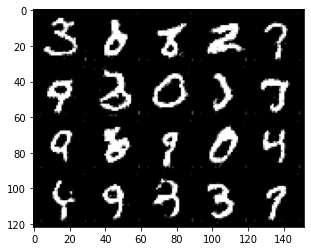

In [17]:
show_images(fake_images, (1,28,28))

<h3>show real images</h3>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


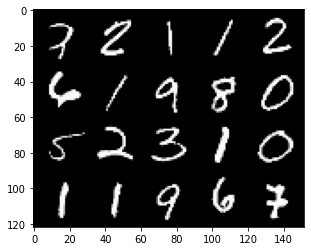

In [18]:
real_images = real_images[:20].view(-1, 28, 28)

show_images(real_images, (1, 28, 28))